In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cmocean.cm as cmo
from scipy.interpolate import griddata
from datetime import datetime, timedelta
import gsw
import datetime
import cartopy.crs as ccrs
from pathlib import Path
import cmasher as cmr
from skimage.morphology import dilation
from skimage.morphology import disk
import matplotlib.colors as mcolors
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
from matplotlib import colors as c

xr.set_options(keep_attrs=True)
plt.rcParams['font.size']=14

In [2]:
ds1=xr.open_mfdataset('/home/birte/Maud12_sensitivityruns/EXP_tpre02_prsn02_2012/dc_count_201[6,7]_EXP_tpre02_prsn02_2012.nc')
ds1=ds1.rename({'lon':'nav_lon','lat':'nav_lat'})
ds2=xr.open_mfdataset('/home/birte/Maud12_sensitivityruns/EXP_tpre02_prsn02_2012/mld_201[6,7].nc')
ds2=ds2.rename({'nav_lon_grid_T':'nav_lon','nav_lat_grid_T':'nav_lat'})

bat=xr.open_dataset('../../MAUD_RISE_config/maud_v4/m12_mask/1_domain_cfg_50levels_new.nc')

ds=xr.merge((ds2,bat.bathy_meter),compat='override')
ds=ds.isel(x=slice(4,-4),y=slice(4,-4))
ds.coords['year']=ds.time_counter.dt.year
ds.coords['month']=ds.time_counter.dt.month
ds.coords['day']=ds.time_counter.dt.day
ds.coords['dayofyear']=ds.time_counter.dt.dayofyear

In [3]:
bat=xr.open_dataset('../../MAUD_RISE_config/maud_v4/m12_mask/1_domain_cfg_50levels_new.nc')
bat.coords['nav_lon']=bat.nav_lon
bat.coords['nav_lat']=bat.nav_lat
bat['mask_tc']=np.zeros((len(bat.y),len(bat.x)))*(bat.bathy_meter.where(bat.bathy_meter<2500))+1
bat['mask_tc']=bat.mask_tc.where(((bat.mask_tc==1)&(bat.glamt<4.3)&(bat.glamt>0.5)&(bat.gphit>-65.5)),other=0)
mask_tc=bat.mask_tc
mask_tc.load()
mask_tc[173,98]=1
mask_tc[178,109]=0

bat['mask_tc']=mask_tc

mean_bathy = bat.bathy_meter.rolling(x=13,center=True).mean().rolling(y=13,center=True).mean()
bat['mask_tr_all']=np.zeros((len(bat.y),len(bat.x)))*(mean_bathy.where(mean_bathy<3500))+1
bat['mask_tr_all']=bat.mask_tr_all.where(((bat.mask_tr_all==1)&(bat.glamt<8)&(bat.gphit>-66.5)),other=0)
bat['mask_tr']=bat.mask_tr_all-bat.mask_tc

mask_tr=bat.mask_tr


bat['mask_ha'] = xr.DataArray(dilation(bat.mask_tr_all, disk(14)) - bat.mask_tr_all,dims=('y', 'x'))
bat['mask_ha']=bat.mask_ha.where(((bat.mask_ha==1)&(bat.bathy_meter<5000)),other=0)
bat['mask_ha_all'] = bat.mask_ha+bat.mask_tr_all
bat['mask_hatr'] = bat.mask_ha+bat.mask_tr
mask_ha=bat.mask_ha
mask_ha=mask_ha.rename("mask_ha")

In [5]:
# Compare this to the observed ice opening locations
dso16=xr.open_mfdataset('/home/birte/observation/sea_ice/reduced_data/sic_20160725.nc')
dso17=xr.open_mfdataset('/home/birte/observation/sea_ice/reduced_data/sic_20170903.nc')
dso=xr.merge((dso16,dso17))
dso.coords['year']=dso.time.dt.year
dso.coords['month']=dso.time.dt.month
dso.coords['day']=dso.time.dt.day
ds16=xr.open_dataset('/home/birte/Maud12_sensitivityruns/EXP_tpre02_prsn02_2012/Maud12t_2016_icemod_grid_T.nc')
ds17=xr.open_dataset('/home/birte/Maud12_sensitivityruns/EXP_tpre02_prsn02_2012/Maud12t_2017_icemod_grid_T.nc')

In [6]:
#defining the threshold for deep convection
dc_thres=830

In [18]:
#identify the onset of deep convection in the year
dcs16=np.int(ds.dayofyear.where((ds.mldr10_1>dc_thres)&(ds.year==2016)).min(dim='time_counter').min().values)
print(dcs16)
#identify the onset of deep convection in each grid cell
dcstart2016=xr.where((ds.mldr10_1.where(ds.year==2016,drop=True).isel(time_counter=dcs16+1)>=dc_thres),1,0)

199


/home/birte/anaconda3/lib/python3.8/site-packages/dask/utils.py:29: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/birte/anaconda3/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))


In [8]:
dcs17=np.int(ds.dayofyear.where((ds.mldr10_1>dc_thres)&(ds.year==2017)).min(dim='time_counter').min().values)
print(dcs17)
dcstart2017=xr.where((ds.mldr10_1.where(ds.year==2017,drop=True).isel(time_counter=dcs17-1)>=dc_thres),1,0)


181


/home/birte/anaconda3/lib/python3.8/site-packages/dask/utils.py:29: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/birte/anaconda3/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))


In [9]:
dcspread16=(ds.dayofyear.where((ds.mldr10_1>=dc_thres)&(ds.year==2016)).min(dim='time_counter')-dcs16)
dcspread17=(ds.dayofyear.where((ds.mldr10_1>=dc_thres)&(ds.year==2017)).min(dim='time_counter')-dcs17)

/home/birte/anaconda3/lib/python3.8/site-packages/dask/utils.py:29: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/birte/anaconda3/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/birte/anaconda3/lib/python3.8/site-packages/dask/utils.py:29: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/birte/anaconda3/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/birte/anaconda3/lib/python3.8/site-packages/dask/utils.py:29: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/birte/anaconda3/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))


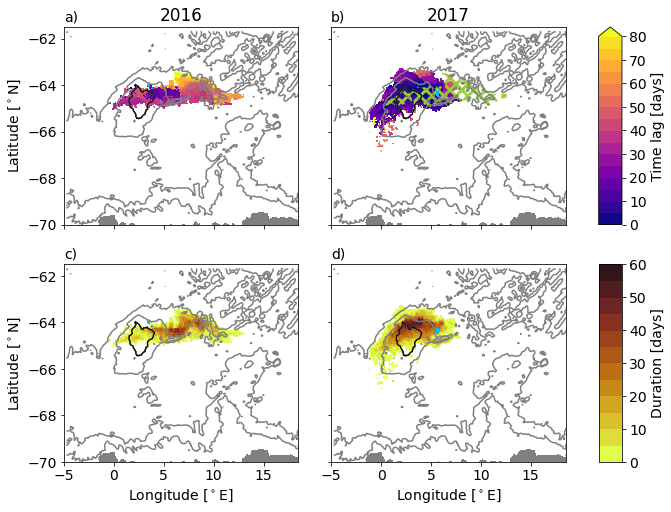

In [79]:
# Figure 6
plt.rcParams['hatch.linewidth'] = 3
dmax=80
dmin=0
dlev=17
dmap='plasma'
cMap_c4= c.ListedColormap([(0.0,0,0,0),(0,0.75,1,1)]) #green

fig,axes=plt.subplots(2,3,figsize=(10,8),gridspec_kw={'width_ratios':[1,1,.1]})
ax=axes[0,0]
(ds.dayofyear.where((ds.mldr10_1>dc_thres)&(ds.year==2016)).min(dim='time_counter')-dcs16).plot.pcolormesh(x="nav_lon",y="nav_lat",vmin=dmin,vmax=dmax,levels=dlev,cmap=dmap,ax=ax,add_colorbar=False)
dcstart2016.where(dcstart2016>0).plot.pcolormesh(x="nav_lon",y="nav_lat",ax=ax,vmin=0,vmax=2,cmap=cMap_c4,add_colorbar=False)
ds.bathy_meter.where(ds.bathy_meter<10).plot.contourf(x="nav_lon",y="nav_lat",colors='grey',add_colorbar=False,ax=ax)
ds.bathy_meter.plot.contour(x="nav_lon",y="nav_lat",levels=[2500,3500,5000],colors='grey',ax=ax)
bat.mask_tc.plot.contour(x="nav_lon",y="nav_lat",colors='k',linestyles='-',linewidths=.7,alpha=.5,ax=ax)

ax.set_title('2016')
ax.set_xlim(-5,18.5)
ax.set_ylim(-70,-61.5)

ax.set_ylabel('Latitude [$^\circ$N]')
ax.set_xlabel('')
ax.set_xticklabels('')
ax.text(0.03, 1.05, 'a)', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes,fontsize='14')
ax=axes[0,1]
cb=(ds.dayofyear.where((ds.mldr10_1>dc_thres)&(ds.year==2017)).min(dim='time_counter')-dcs17).plot.pcolormesh(x="nav_lon",y="nav_lat",vmin=dmin,vmax=dmax,levels=dlev,cmap=dmap,ax=ax,add_colorbar=False)
cs=dcspread16.plot.contourf(x="nav_lon",y="nav_lat",hatches=['xx'],colors='none',ax=ax,add_colorbar=False)
#dcspread16.plot.contourf(x="nav_lon",y="nav_lat",hatches='x',colors='w',ax=ax,alpha=0,add_colorbar=False)
dcstart2017.where(dcstart2017>0).plot.pcolormesh(x="nav_lon",y="nav_lat",ax=ax,vmin=0,vmax=2,cmap=cMap_c4,add_colorbar=False)
ds.bathy_meter.where(ds.bathy_meter<10).plot.contourf(x="nav_lon",y="nav_lat",colors='grey',add_colorbar=False,ax=ax)
ds.bathy_meter.plot.contour(x="nav_lon",y="nav_lat",levels=[2500,3500,5000],colors='grey',ax=ax)
bat.mask_tc.plot.contour(x="nav_lon",y="nav_lat",colors='k',linestyles='-',linewidths=.7,alpha=.5,ax=ax)

ax.set_title('2017')
ax.set_xlim(-5,18.5)
ax.set_ylim(-70,-61.5)

ax.set_ylabel('')
ax.set_xlabel('')
ax.set_yticklabels('')
ax.set_xticklabels('')
ax.text(0.03, 1.05, 'b)', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes,fontsize='14')

plt.colorbar(cb,cax=axes[0,2], label='Time lag [days]')

# coloring the hatch
colors = ['yellowgreen']
# For each level, we set the color of its hatch 
for i, collection in enumerate(cs.collections):
    collection.set_edgecolor(colors[i % len(colors)])
for collection in cs.collections:
    collection.set_linewidth(0.)
    
from matplotlib import colors as c

dmax=60
dmin=0
dlev=13
dmap=cmo.solar_r
ax=axes[1,0]
(ds1.dc_830.where(ds1.dc_830>0).isel(year=0)).plot.pcolormesh(x="nav_lon",y="nav_lat",vmin=dmin,vmax=dmax,levels=dlev,cmap=dmap,ax=ax,add_colorbar=False)
dcstart2016.where(dcstart2016>0).plot.pcolormesh(x="nav_lon",y="nav_lat",ax=ax,vmin=0,vmax=2,cmap=cMap_c4,add_colorbar=False)
ds.bathy_meter.where(ds.bathy_meter<10).plot.contourf(x="nav_lon",y="nav_lat",colors='grey',add_colorbar=False,ax=ax)
ds.bathy_meter.plot.contour(x="nav_lon",y="nav_lat",levels=[2500,3500,5000],colors='grey',ax=ax)
bat.mask_tc.plot.contour(x="nav_lon",y="nav_lat",colors='k',linestyles='-',linewidths=.7,alpha=.5,ax=ax)

ax.set_title('')
ax.set_xlim(-5,18.5)
ax.set_ylim(-70,-61.5)
ax.set_ylabel('Latitude [$^\circ$N]')
ax.set_xlabel('Longitude [$^\circ$E]')
ax.text(0.03, 1.05, 'c)', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes,fontsize='14')
ax=axes[1,1]
cb=(ds1.dc_830.where(ds1.dc_830>0).isel(year=1)).plot.pcolormesh(x="nav_lon",y="nav_lat",vmin=dmin,vmax=dmax,levels=dlev,cmap=dmap,ax=ax,add_colorbar=False)
dcstart2017.where(dcstart2017>0).plot.pcolormesh(x="nav_lon",y="nav_lat",ax=ax,vmin=0,vmax=2,cmap=cMap_c4,add_colorbar=False)
ds.bathy_meter.where(ds.bathy_meter<10).plot.contourf(x="nav_lon",y="nav_lat",colors='grey',add_colorbar=False,ax=ax)
ds.bathy_meter.plot.contour(x="nav_lon",y="nav_lat",levels=[2500,3500,5000],colors='grey',ax=ax)
bat.mask_tc.plot.contour(x="nav_lon",y="nav_lat",colors='k',linestyles='-',linewidths=.7,alpha=.5,ax=ax)

ax.set_title('')
ax.set_xlim(-5,18.5)
ax.set_ylim(-70,-61.5)


ax.set_ylabel('')
ax.set_xlabel('Longitude [$^\circ$E]')
ax.set_yticklabels('')

ax.text(0.03, 1.05, 'd)', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes,fontsize='14')

plt.colorbar(cb,cax=axes[1,2], label='Duration [days]',ticks=np.linspace(dmin,dmax,7))
plt.savefig('./dc_timelag_duration_%d.jpg'%dmax,dpi=300)


In [10]:
print((ds1.dc_830.where(ds1.dc_830>0).isel(year=0)).max().values)
print((ds1.dc_830.where(ds1.dc_830>0).isel(year=1)).max().values)

47.0
59.0


In [11]:
print(ds16.time_counter.isel(time_counter=dcs16-1).values)
print(ds17.time_counter.isel(time_counter=dcs17-1).values)

2016-07-17T12:00:00.000000000
2017-06-30T12:00:00.000000000


In [12]:
dc16_lon=ds.nav_lon.where(dcstart2016>0,drop=True)#.mean(dim={'x','y'})
dc16_lon.values

array([[3.4166667]], dtype=float32)

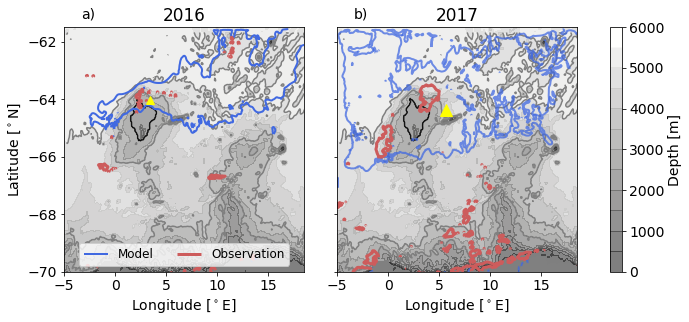

In [31]:
# Figure 5 
fig,axes=plt.subplots(1,3,figsize=(10,4.5),gridspec_kw={'width_ratios':[1,1,0.05]})
ax=axes[0]
bat.bathy_meter.where(bat.bathy_meter>1).plot.contourf(x="nav_lon",y="nav_lat",vmin=0,vmax=6000,levels=13,cmap=cmo.gray,add_colorbar=False,alpha=.5,ax=ax)#,add_colorbar=False)#',add_colorbar=False)
bat.bathy_meter.where(bat.bathy_meter<1).plot.contourf(x="nav_lon",y="nav_lat",colors='gray',add_colorbar=False,ax=ax)
ds.bathy_meter.plot.contour(x="nav_lon",y="nav_lat",levels=[2500,3500,5000],colors='grey',ax=ax)
bat.mask_tc.plot.contour(x="nav_lon",y="nav_lat",colors='k',linestyles='-',linewidths=.7,alpha=.5,ax=ax)

sicmod_16=ds16.siconc.isel(time_counter=dcs16-1).plot.contour(x="nav_lon",y="nav_lat",levels=[0.5],colors='royalblue',linewidths=2,linestyles='-',ax=ax)
sicmod16, labels = sicmod_16.legend_elements()

sicobs_16=dso.z.isel(time=0).plot.contour(x="lon",y="lat",levels=[50],colors='indianred',linestyles='-',linewidths=3,ax=ax)
sicobs16, labels = sicobs_16.legend_elements()
ax.plot(ds.nav_lon.where(dcstart2016>0),ds.nav_lat.where(dcstart2016>0),ls='',marker='^',c='yellow',markersize=8)

ax.set_xlim(-5,18.5)
ax.set_ylim(-70,-61.5)
ax.set_ylabel('Latitude [$^\circ$N]')
ax.set_xlabel('Longitude [$^\circ$E]')
ax.set_title('2016')
axes[0].legend(sicmod16+sicobs16,
         ["Model","Observation"],frameon=True,ncol=2,loc="lower center",fontsize=12)
ax.text(0.1, 1.05, 'a)', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)
ax=axes[1]
cb=bat.bathy_meter.where(bat.bathy_meter>1).plot.contourf(x="nav_lon",y="nav_lat",vmin=0,vmax=6000,levels=13,cmap=cmo.gray,alpha=.5,ax=ax,add_colorbar=False)#',add_colorbar=False)
bat.bathy_meter.where(bat.bathy_meter<1).plot.contourf(x="nav_lon",y="nav_lat",colors='gray',add_colorbar=False,ax=ax)
ccbat1=ds.bathy_meter.plot.contour(x="nav_lon",y="nav_lat",levels=[2500,3500,5000],colors='grey',ax=ax)
bat.mask_tc.plot.contour(x="nav_lon",y="nav_lat",colors='k',linestyles='-',linewidths=.7,alpha=.5,ax=ax)



sicmod_17=ds17.siconc.isel(time_counter=dcs17-1).plot.contour(x="nav_lon",y="nav_lat",levels=[0.5],colors='royalblue',linewidths=2,linestyles='-',alpha=.75,ax=ax)
sicmod17, labels = sicmod_17.legend_elements()
sicobs_17=dso.z.isel(time=1).plot.contour(x="lon",y="lat",levels=[50],colors='indianred',linestyles='-',linewidths=3,ax=ax)
sicobs17, labels = sicobs_17.legend_elements()


ax.plot(ds.nav_lon.where(dcstart2017>0).mean(dim={'x','y'}),ds.nav_lat.where(dcstart2017>0).mean(dim={'x','y'}),ls='',marker='^',c='yellow',markersize=12)
ax.text(0.1, 1.05, 'b)', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)

ax.set_xlim(-5,18.5)
ax.set_ylim(-70,-61.5)
ax.set_ylabel('')
ax.set_title('2017')
ax.set_yticklabels('')
ax.set_xlabel('Longitude [$^\circ$E]')

cbar=plt.colorbar(cb,cax=axes[2],label='Depth [m]')
plt.tight_layout

plt.savefig('./dc_initial_toseaice.jpg',dpi=300)